# Phosphorus Machine Learning Project

### See `utils.py` for the bones of the code.

### This notebook is exclusively for visualization.

In [28]:
import utils
from utils import *

from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in Data

In [3]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

### Create dictionary maps for each CID based on different codes

In [29]:
X_data_classed = [c for c in X_data if c['Class']!='None']
compoundmap = {compound['CID']:compound for compound in X_data_classed}

CIDs = np.array([c['CID'] for c in X_data_classed])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

# CLASSSIFICATION MAPS
# classes
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in CLASSCODES.keys()}
classnames = list(CLASSCODES.keys())[:-1]

# coordination
coordcodemap = {compound['CID']:COORDCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in COORDCODES.keys()}
# phosphorane subclasses
phosphoranecodemap = {compound['CID']:PHOSPHORANECODES[compound['Class']] for compound in X_data_classed
                      if compound['Class'] in PHOSPHORANECODES.keys()}
# sulfur subclasses
sulfurcodemap = {compound['CID']:SULFURCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in SULFURCODES.keys()}

# OH subclasses
ohcodemap = {compound['CID']:OHCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in OHCODES.keys()}

# chargemap
chargemap = {compound['CID']:compound['Charge'] for compound in X_data_classed}

# t-SNE Analysis

## Spaghetti Plot

In [6]:
# codemap = coordcodemap

# hiddenCIDS = np.array([c['CID'] for c in X_data if not c['CID'] in codemap.keys()])

# xesspagplt = plot_spaghetti(plt.subplots(figsize=(6,8)), compoundmap, colorcodemap=codemap, binmap=codemap,
#                mode='XES', coloralpha=0.1, hiddencids=hiddenCIDS, colormap=plt.cm.tab10, hiddenalpha=0, scale=False)
# xanesspagplt = plot_spaghetti(plt.subplots(figsize=(6,8)), compoundmap, colorcodemap=codemap, binmap=codemap,
#                mode='XANES', coloralpha=0.1, hiddencids=hiddenCIDS, colormap=plt.cm.tab10, hiddenalpha=0, scale=False)

## PCA + t-SNE

VtC-XES takes 6 PCs to explain 0.9015 variance
XANES takes 12 PCs to explain 0.9088 variance


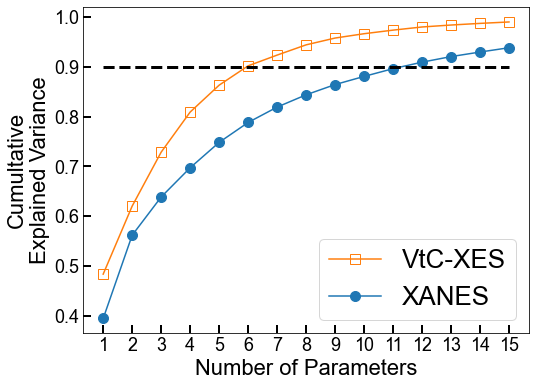

In [7]:
XES = np.array([c['XES_Normalized'] for c in X_data_classed])
XANES = np.array([c['XANES_Normalized'] for c in X_data_classed])

# pca
pca_all_xes = PCA()
XES_PCA = pca_all_xes.fit_transform(XES)
pca_all_xanes = PCA()
XANES_PCA = pca_all_xanes.fit_transform(XANES)

N = XANES_PCA.shape[1]

explained_var_xes = np.array([np.sum(pca_all_xes.explained_variance_ratio_[:i+1]) for i in range(N)])
explained_var_xanes = np.array([np.sum(pca_all_xanes.explained_variance_ratio_[:i+1]) for i in range(N)])

threshold_xes = np.where(explained_var_xes >= 0.9)[0][0]
threshold_xanes = np.where(explained_var_xanes >= 0.9)[0][0]

print(f"VtC-XES takes {threshold_xes+1} PCs to explain {explained_var_xes[threshold_xes]:.04f} variance")
print(f"XANES takes {threshold_xanes+1} PCs to explain {explained_var_xanes[threshold_xanes]:.04f} variance")

make_stacked_scree(pca_all_xes.explained_variance_ratio_, pca_all_xanes.explained_variance_ratio_, n=15)

# Coordination

In [8]:
X_coord, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XES')
X_coord, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XANES')

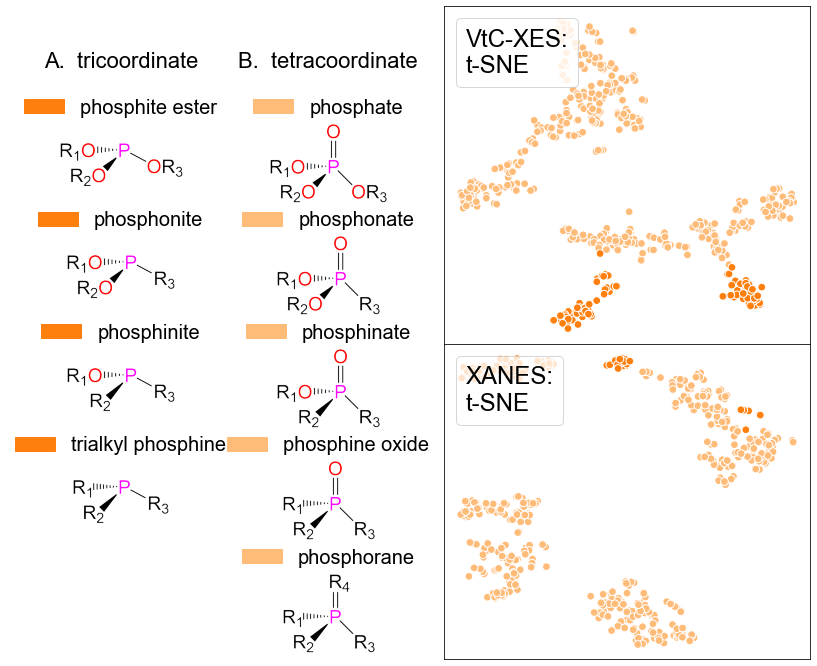

In [9]:
fig = plt.figure(figsize=(14,12))
asize = 0.25
spec = fig.add_gridspec(nrows=11, ncols=3,
                        width_ratios = [0.5, .5, 1.],
                        height_ratios=[1, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.1, hspace=0)

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/{clsname}.png') for clsname in tetra]

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/{clsname}.png') for clsname in tri]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate\n', 'B.  tetracoordinate\n']

# colorcode, codemap = CLASSCODES, classcodemap
colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # make legend
        legax = fig.add_subplot(spec[2*i + 1,j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=20, framealpha=0, frameon=False)
        legax.axis('off')
        # show structure
        structax = fig.add_subplot(spec[2*i + 2,j])
        if j == 0:
            structure = resize(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('off')
        
        if i == 0:
            legax.set_title(titles[j], fontsize=22)
            
ax = fig.add_subplot(spec[:6,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                              mode='XES', method='t-SNE', hiddencids=hiddenCIDS, fontsize=24,
                              size=60, edgecolors='w')

ax = fig.add_subplot(spec[6:11,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                              mode='XANES', method='t-SNE', hiddencids=hiddenCIDS, fontsize=24,
                              size=60, edgecolors='w')

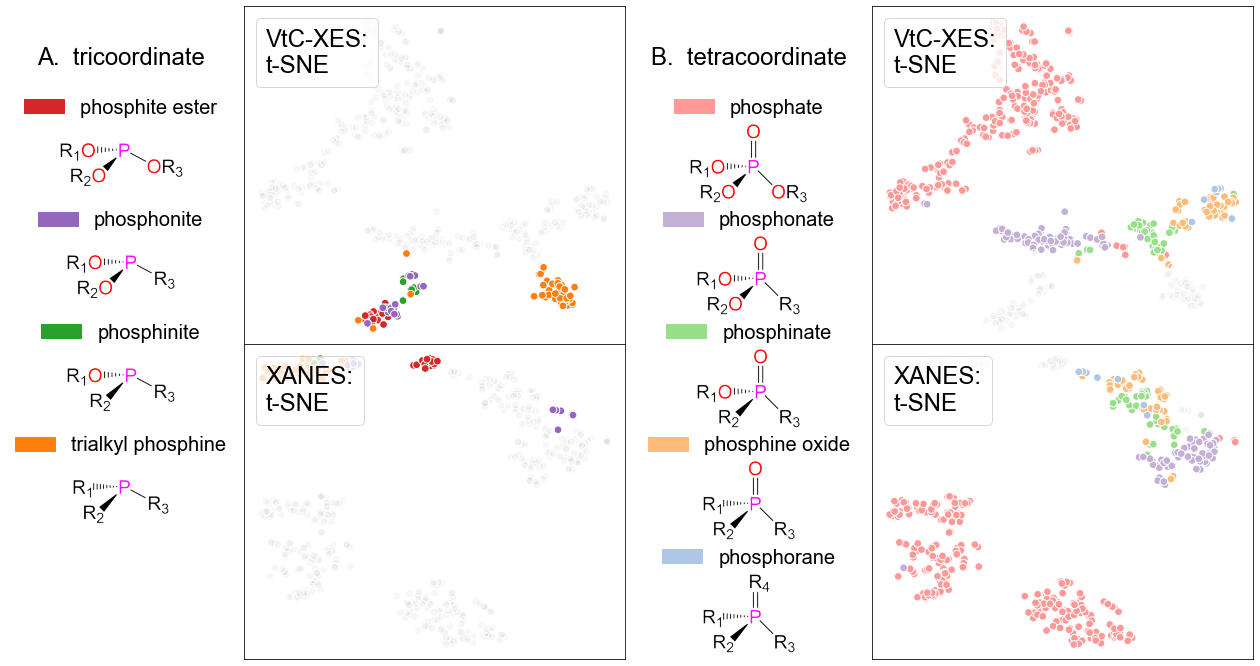

In [10]:
fig = plt.figure(figsize=(22,12))
asize = 0.25
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.5, 1., 0.5, 1.],
                        height_ratios=[1, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.1, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate\n', 'B.  tetracoordinate\n']

colorcode, codemap = CLASSCODES, classcodemap
# colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                              fontsize=20, framealpha=0, frameon=False)
        legax.axis('off')
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        structax.axis('off')
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([3,4]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                                  mode='XES', method='t-SNE', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                                  mode='XANES', method='t-SNE', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.03)

In [11]:
# tricoord_classes = [k for k,v in COORDCODES.items() if v == 3]
# kwargs = {'Class': tricoord_classes}

# fig = plt.figure(figsize=(15,12))
# spec = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[0.4, 1, 1])
# plt.subplots_adjust(wspace=0, hspace=0)

# for mode in ['XES', 'XANES']:
#     if mode == 'XES':
#         tsnemap = XES_tsnemap
#         col = 1
#     else:
#         tsnemap = XANES_tsnemap
#         col = 2
        
#     ax = fig.add_subplot(spec[0, col])
#     tsneplt = plot_dim_red((fig, ax), X_coord, tsnemap,
#                            colorcodemap=coordcodemap, size=60, edgecolors='w',
#                            mode=mode, method='t-SNE', hiddencids=hiddenCIDS, fontsize=27)
    
#     if mode == 'XES':
#         label=['a', 'b']
#         kwargs = {'Class': tricoord_classes, 'CID': [129643930, 10304870]}
#     else:
#         kwargs = {'Class': tricoord_classes}
#         label = None
        
#     ax = fig.add_subplot(spec[1, col])
#     tricoord_tsneplt = plot_dim_red((fig, ax), X_coord, tsnemap, size=70,
#                                      colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.03,
#                                      label=label, mode=mode, method='t-SNE', fontsize=28, edgecolors='w',
#                                      **kwargs)
#     if mode == 'XES':
#         legend_labels = ['tricoordinate', 'tetracoordinate']
#         ax = fig.add_subplot(spec[0, 0])
#         make_legend((fig, ax), legend_labels, None, codes={'tricoordinate':3, 'tetracoordinate':4},
#                          include_structures=False)
#     else:
#         legend_labels = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
#         ax = fig.add_subplot(spec[1, 0])
#         make_legend((fig,ax), legend_labels, None, include_structures=False)

In [12]:
# tricoord_classes = [k for k,v in COORDCODES.items() if v == 3]
# tricoord_classes.remove('phosphite_ester')
# figsize=(6,6)
# kwargs = {'Class': tricoord_classes, 'CID': [136869, 118143996]}
# label = ['c','d']
        
# tricoord_tsneplt = plot_dim_red(plt.subplots(figsize=figsize), X_coord, XANES_tsnemap, size=180,
#                                 colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.0,
#                                 mode='XANES', method='t-SNE', fontsize=30, edgecolors='w',
#                                 label=label, show_legend=False, **kwargs) 

# Charge

C:\Users\saman\Downloads\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


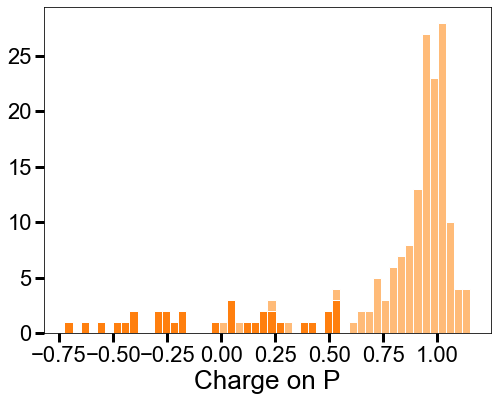

In [13]:
chargemap_coord = {compound['CID']:compound['Charge'] for compound in X_coord}
make_charge_hist(chargemap_coord, colorcodemap=coordcodemap)    

## Phosphate subclusters

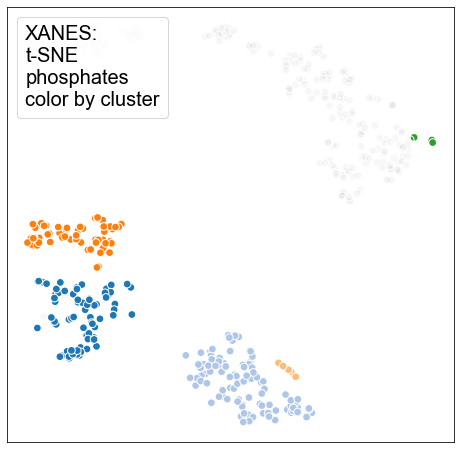

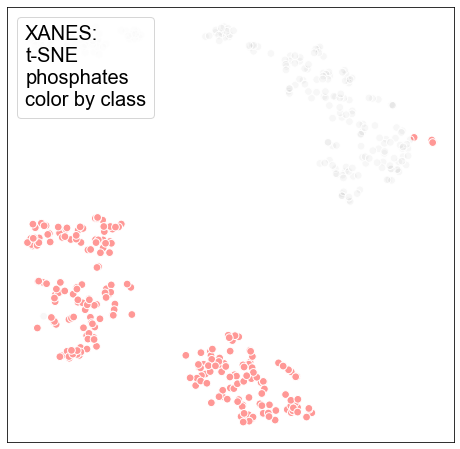

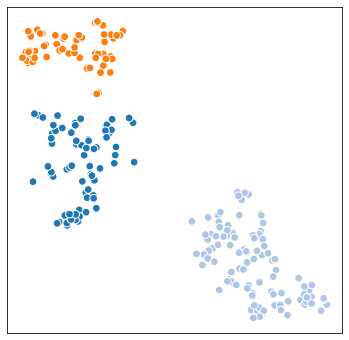

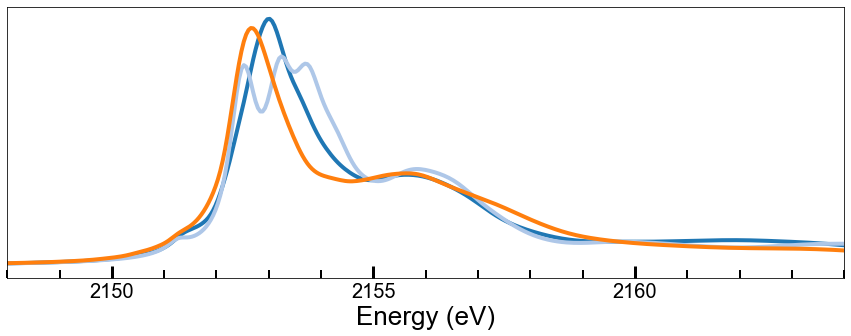

In [14]:
options = {'loc':2, 'title': None}
kwargs = {'Class': ['phosphate']}

############ create DBScan clusters
tsne_phosphates = np.array([XANES_tsnemap[c['CID']] for c in X_data_classed if c['Class'] == 'phosphate'])
cids_phosphates = [c['CID'] for c in X_data_classed if c['Class'] == 'phosphate']

dbscan_clustering = DBSCAN(eps=3.3, min_samples=1).fit(tsne_phosphates)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

############ plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {}
for c in X_data_classed:
    if c['Class'] == 'phosphate':
        phosphate_clustermap[c['CID']] = dbscan_clustermap[c['CID']] + 1
    else:
        phosphate_clustermap[c['CID']] = 0
              
select_clusters = [1,2,3]
X_phosphate = [c for c in X_data_classed if phosphate_clustermap[c['CID']] in select_clusters]

colorcodemap = {c['CID']:phosphate_clustermap[c['CID']] for c in X_data_classed \
          if phosphate_clustermap[c['CID']] in select_clusters}
binmap = {k:v*0.5 for k,v in colorcodemap.items()}

############ tsne plot all phosphates with clusters indicated by DBSCAN
tsne_plt = plot_dim_red(plt.subplots(figsize=(8,8)), X_coord, XANES_tsnemap, size=60,
                        colorcodemap=phosphate_clustermap, coloralpha=1., hiddenalpha=0.03,
                        mode='XANES', method='t-SNE\nphosphates\ncolor by cluster', fontsize=20, edgecolors='w',
                        **Merge(kwargs, options))

############ tsne plot all phosphates all one color
tsne_plt = plot_dim_red(plt.subplots(figsize=(8,8)), X_coord, XANES_tsnemap, size=60,
                        colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.03, fontsize=20,
                        mode='XANES', method='t-SNE\nphosphates\ncolor by class', edgecolors='w',
                        **Merge(kwargs, options))

############ zoomed in on clusters
tsne_plt = plot_dim_red(plt.subplots(figsize=(6,6)), X_phosphate, XANES_tsnemap, size=60,
                        colorcodemap=phosphate_clustermap, coloralpha=1., hiddenalpha=0.03,
                        mode='XANES', method='t-SNE', fontsize=20, edgecolors='w', show_legend=False,
                        **Merge(kwargs, options))

############ spaghetti plot of average clusters indicated by DBSCAN
spaghetti_plt = plot_spaghetti(plt.subplots(figsize=(15,5)), compoundmap, mode='XANES',
                               colorcodemap=colorcodemap, binmap=binmap, linewidth=4, energyrange=(2148,2164),
                               hiddenalpha=0, coloralpha=1.0, average_bins=True, **Merge(kwargs, options))

In [15]:
# cids = [151020, 3034794]
# III: 11242708 
# II: 
# I: 
# labels = ['Ia', 'Ib']
# for i, cid in enumerate(cids):
#     plot_spectrum_and_trans((fig, axes[i]), compoundmap, cid, verbose=True,
#                                 mode='XANES', energyrange=(2148,2169), color=0,
#                                 link_pubchem=True, label=labels[i])

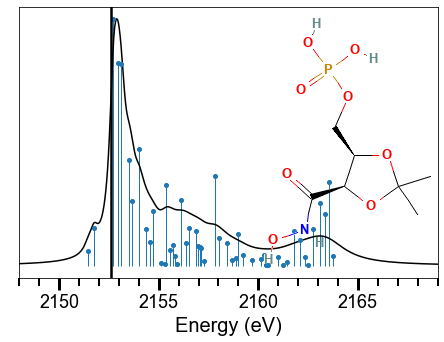

In [16]:
cid = 11242708
# cid = 107737
# cid = 122250
plot_spectrum_and_trans(plt.subplots(figsize=(7.5,5)), compoundmap, cid, verbose=True,
                                     mode='XANES', energyrange=(2148,2169), color=dbscan_clustermap[cid],
                                     link_pubchem=True)

In [17]:
# for select in [0,1,2]:
#     cids = []
#     for cid, cluster in dbscan_clustermap.items():
#         if cluster == select and compoundmap[cid]['Charge'] != -1:
#             cids += [cid]

#     N = 6
#     cids = np.array(cids[:N*2]).reshape((2,N))
#     print(cids)
    
#     fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
#     plt.subplots_adjust(wspace=0, hspace=0)

#     for cluster, cid_list in enumerate(cids):
#         for i, cid in enumerate(cid_list):
#             if i == N-1:
#                 verbose = True
#             else:
#                 verbose = False
#             plot_spectrum_and_trans((fig, axes[i, cluster]), compoundmap, cid, verbose=verbose,
#                                     mode='XANES', energyrange=(2148,2169), color=select,
#                                     link_pubchem=True)

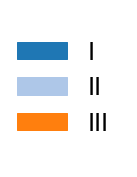

In [18]:
labels= ['I', 'II', 'III']
pattern = None
plot = plt.subplots(figsize=(2,3))
fig = make_legend(plot, labels, pattern, codes={'I':1, 'II':2, 'III':3}, include_structures=False)

In [19]:
# 186 vs 466 (both have OH H-bonded intramolecularly but 466 has additional H bond with OR group)
# same with 186 vs 11988266
# vs 107737 (2 OH with only OR H-bonded)
# 10541 vs 13134 (3 H bonds for all 3 Os vs just 2 Os)
# same with 6535 vs 654
# 120825 vs 13869 (1 H bond each vs 2 H-bonds each)
# 11207678 vs 104993 (2 OR H bonding vs 1)

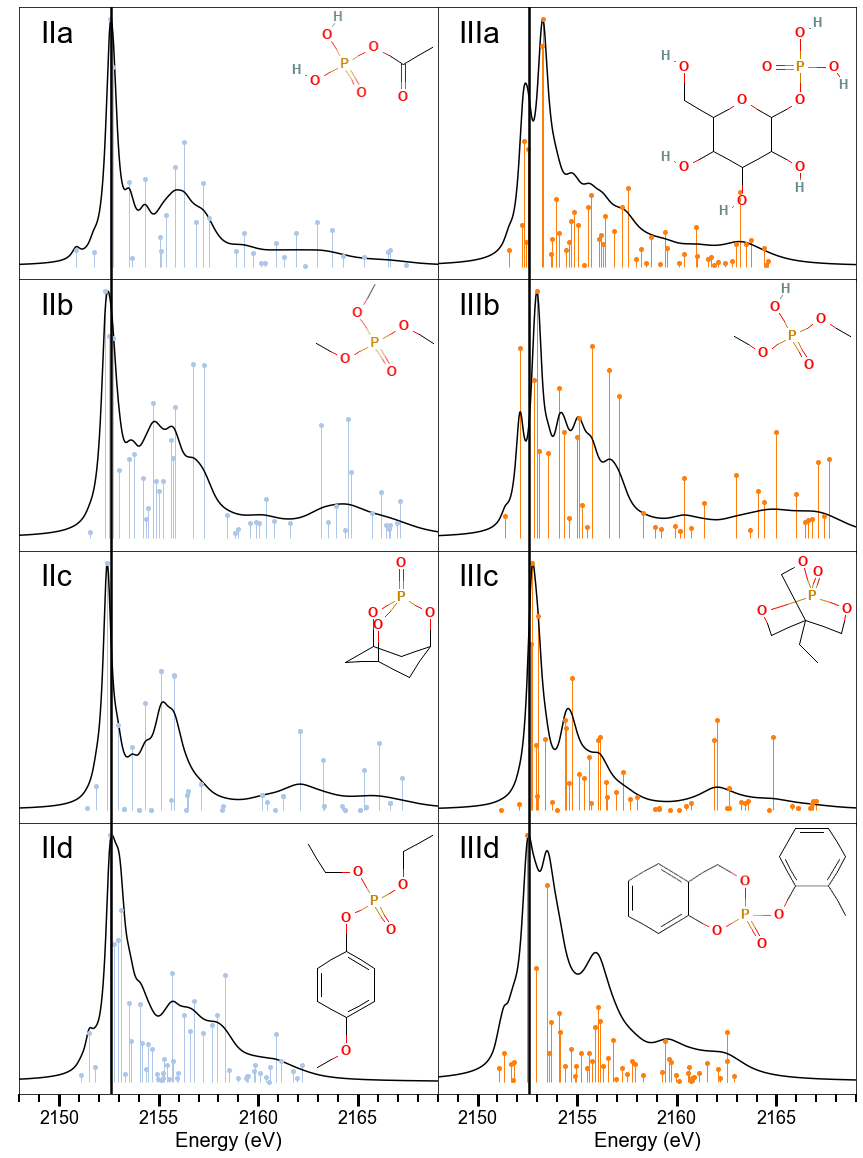

In [20]:
cluster_cids = np.array([[186, 10541, 120825, 11207678],[466, 13134, 13869, 104993]])
N = cluster_cids.shape[1]

fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
plt.subplots_adjust(wspace=0, hspace=0)
# labels = [['a', 'c', 'e', 'g'], ['b', 'd', 'f', 'h']]
labels = [['IIa', 'IIb', 'IIc', 'IId'], ['IIIa', 'IIIb', 'IIIc', 'IIId']]

for cluster, cid_list in enumerate(cluster_cids):
    for i, cid in enumerate(cid_list):
        if i == N-1:
            verbose = True
        else:
            verbose = False
        plot_spectrum_and_trans((fig, axes[i, cluster]), compoundmap, cid, verbose=verbose,
                                mode='XANES', energyrange=(2148,2169), color=cluster+1,
                                link_pubchem=True, label=labels[cluster][i])

# Other subset analysis

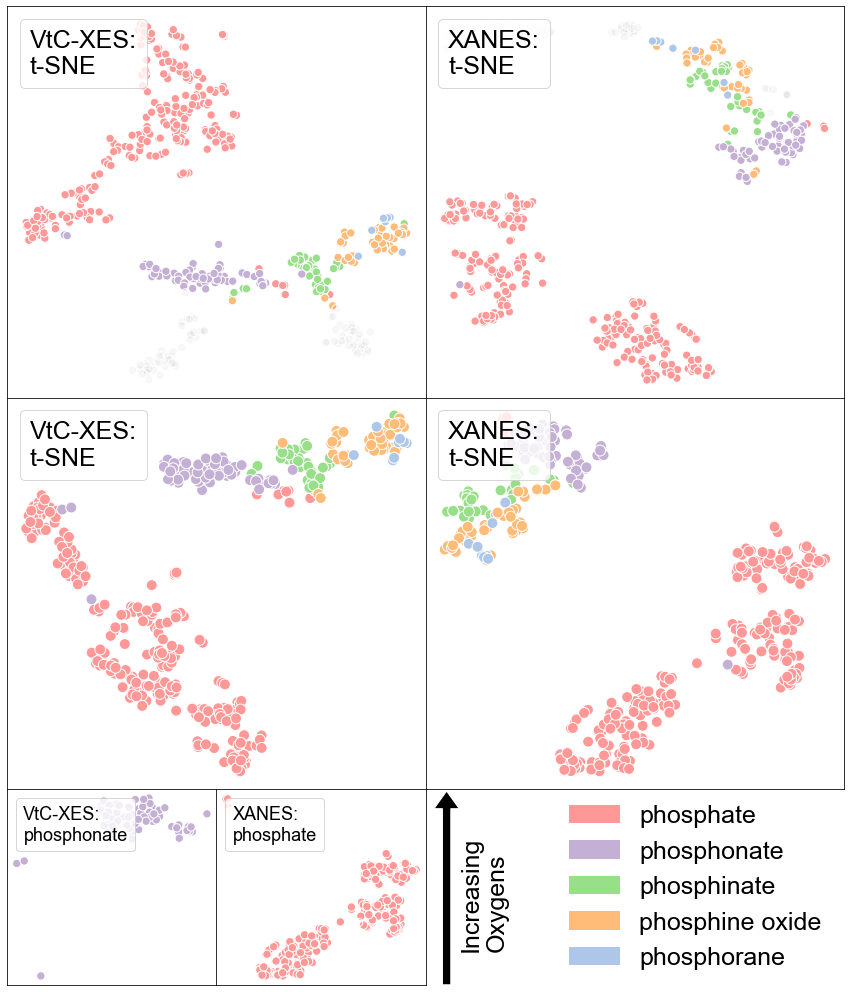

In [21]:
# select = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
select = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
# select = ['phosphinate', 'phosphenic_acid']

fig = plt.figure(figsize=(15,18))
spec = fig.add_gridspec(nrows=3, ncols=4, height_ratios=[1, 1, 0.5])
plt.subplots_adjust(wspace=0, hspace=0)

for mode in ['XES', 'XANES']:
    kwargs = {'Class': select}
    colormap = plt.cm.tab20
    if mode == 'XES':
        tsnemap = XES_tsnemap
        perp = 16
        sub_kwargs = {'Class': ['phosphonate']}
        col = 0
    else:
        tsnemap = XANES_tsnemap
        perp = 12
        sub_kwargs = {'Class': ['phosphate']}
        col = 2
        
    #################### tsne plot ensemble
    ax = fig.add_subplot(spec[0, col:col+2])
    tsne_plt = plot_dim_red((fig, ax), X_coord, tsnemap, size=70,
                            colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='t-SNE', fontsize=25, colormap=colormap,
                            edgecolors='w', **kwargs)

    #################### tsne subset plot: using kwargs
    X_subset, tsnemap_sub, reduced_space_TSNE, hiddenCIDS = get_subset_maps(X_coord, coordcodemap, mode=mode,
                                                                           **kwargs)
    
    ax = fig.add_subplot(spec[1, col:col+2])
    tsne_sub_plt = plot_dim_red((fig, ax), X_subset, tsnemap_sub,
                                colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.3,
                                mode=mode, method=f't-SNE', size=120, fontsize=25,
                                colormap=colormap, edgecolors='w', **kwargs)    
    if mode == 'XES':
        ################### tsne plot ensemble: only show sub-classes
        ax = fig.add_subplot(spec[2, 0])
        method = sub_kwargs['Class'][0]
        tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap_sub,
                                colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.0,
                                mode=mode, method=f'{method}', size=70, fontsize=18,
                                colormap=colormap, edgecolors='w', **Merge(kwargs, sub_kwargs))
    else:
        ################### tsne plot ensemble: only show sub-classes
        ax = fig.add_subplot(spec[2, 1])
        method = sub_kwargs['Class'][0]
        tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap_sub,
                                colorcodemap=classcodemap, coloralpha=1., hiddenalpha=0.0,
                                mode=mode, method=f'{method}', size=70, fontsize=18,
                                colormap=colormap, edgecolors='w', **Merge(kwargs, sub_kwargs))
        
        #################### make legend subplot
        labels = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
        pattern = "Increasing\nOxygens"
        ax = fig.add_subplot(spec[2, col:col+2])
        fig = make_legend((fig, ax), labels, pattern, include_structures=False)

## Sulfur-included bonding environment

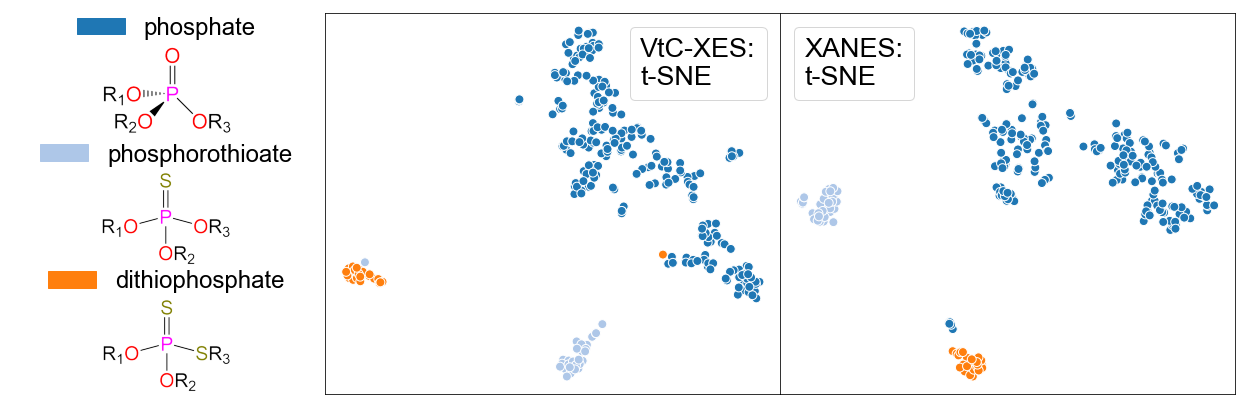

In [23]:
# sulfur subclasses
codemap = sulfurcodemap
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
bin_names = list(SULFURCODES.keys())
N = len(labels)

fig = plt.figure(figsize=(22,7))
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.7, 1, 1],
                        height_ratios=[0.3, 1, 0.3, 1, 0.3, 1])
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}

X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES', perplexity=20,
                                                              **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES', perplexity=18,
                                                                  **kwargs)

structures = [plt.imread(f'../Figures/{clsname}.png') for clsname in labels]

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(i), label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                          fontsize=24, framealpha=0, frameon=False)
    legax.axis('off')
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('off')

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col = 1
        options = {'loc':1}
    else:
        tsnemap = XANES_tsnemap
        col = 2
        options = {'loc':2}
    #################### tsne plot
    ax = fig.add_subplot(spec[:N*2,col])
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='t-SNE', fontsize=27, edgecolors='w',
                            **Merge(kwargs, options)) 
    
    add_point_pubchem_link(tsne_plt, X_subset)

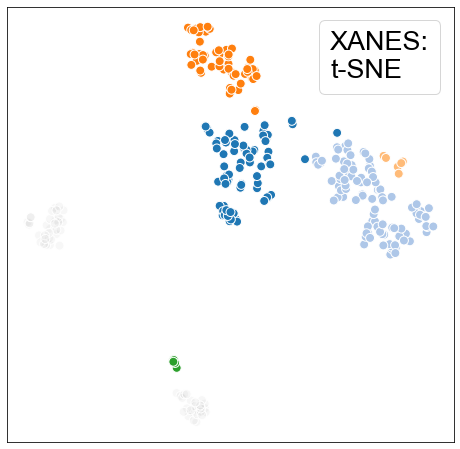

In [24]:
hiddenCIDS += [cid for cid, cluster in phosphate_clustermap.items() if cluster == 0]
tsne_plt = plot_dim_red(plt.subplots(figsize=(8,8)), X_subset, tsnemap, size=80, hiddencids=hiddenCIDS,
                            colorcodemap=phosphate_clustermap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='t-SNE', fontsize=27, edgecolors='w',
                            **Merge(kwargs, {'loc': 1})) 
    
add_point_pubchem_link(tsne_plt, X_subset)

# OH group dependence

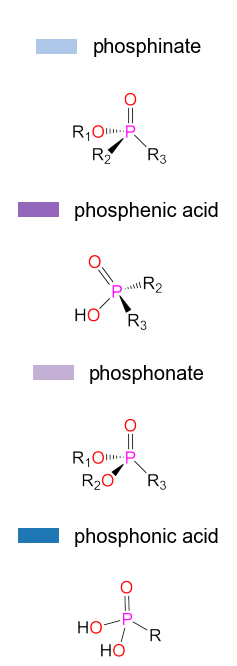

In [34]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'phosphonic_acid']
structures = [Image.open(f'../Figures/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap

N = len(labels)
fig = plt.figure(figsize=(4,12))
spec = fig.add_gridspec(nrows=N*2, ncols=1)
plt.subplots_adjust(wspace=0.1, hspace=0)

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[2*i])
    patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                          fontsize=20, framealpha=0, frameon=False)
    legax.axis('off')
        
    # show structure
    structax = fig.add_subplot(spec[2*i + 1])
#     structure = resize(structure, ratio=(1,1.8))
    structax.imshow(structure)
    structax.axis('off')

In [40]:
kwargs = {'Class': labels}

X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES', perplexity=25,
                                                              **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES', perplexity=30,
                                                                  **kwargs)

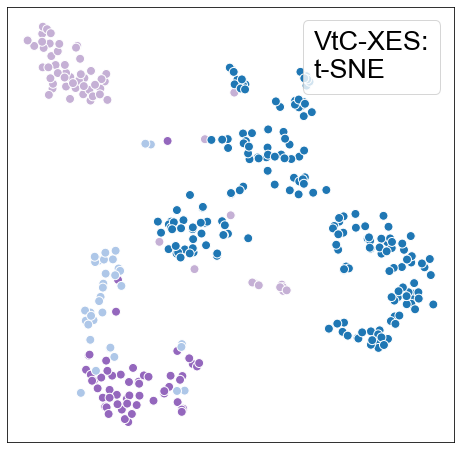

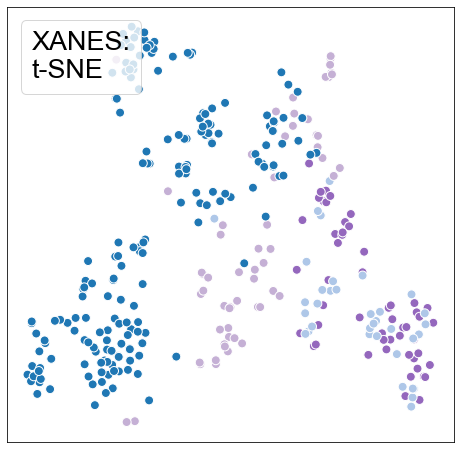

In [41]:
for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col = 1
        options = {'loc':1}
    else:
        tsnemap = XANES_tsnemap
        col = 2
        options = {'loc':2}
    #################### tsne plot
#     ax = fig.add_subplot(spec[:N*2,col])
    tsne_plt = plot_dim_red(plt.subplots(figsize=(8,8)), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='t-SNE', fontsize=27, edgecolors='w',
                            **Merge(kwargs, options)) 